In [6]:
# 1. Imports & Config
import pandas as pd
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- SETUP PATH ---
PROJECT_ROOT = '/content/drive/MyDrive/NFL_Prediction_System'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils import config

# --- SETUP OUTPUT DIRECTORY ---
OUTPUT_DIR = config.MODELS_DIR / "advanced" / "NV"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✅ Setup Complete. Artifacts will be saved to: {OUTPUT_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup Complete. Artifacts will be saved to: /content/drive/MyDrive/NFL_Prediction_System/models/advanced/NV


In [7]:
# 2. Load Data
features_df = pd.read_parquet(config.FEATURES_DIR / 'features_master_2003_2023.parquet')

In [8]:
# 3. Define Features (NO VEGAS)
TARGET = 'home_win'
drop_cols = [
    'game_id', 'season', 'week', 'home_team', 'away_team',
    'home_score', 'away_score', 'home_win', 'home_cover', 'over_hit',
    'spread_line', 'total_line' # <--- DROP VEGAS
]
feature_cols = [col for col in features_df.columns if col not in drop_cols]

X = features_df[feature_cols].copy().fillna(0)
y = features_df[TARGET].copy()

In [9]:
# 4. Split
TEST_SEASON = 2023
X_train = X[features_df['season'] < TEST_SEASON]
y_train = y[features_df['season'] < TEST_SEASON]
X_test = X[features_df['season'] == TEST_SEASON]
y_test = y[features_df['season'] == TEST_SEASON]

# 5. Scale (Critical for Feature Importance Plot)
scaler = StandardScaler()
X_train_scaled_np = scaler.fit_transform(X_train)
X_test_scaled_np = scaler.transform(X_test)

# Convert back to DataFrame to preserve column names for plotting
X_train_scaled = pd.DataFrame(X_train_scaled_np, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled_np, columns=X_test.columns)

print(f"✅ Data Prepared for XGBoost (NV):")
print(f"   - Train: {X_train.shape}")
print(f"   - Test: {X_test.shape}")

✅ Data Prepared for XGBoost (NV):
   - Train: (4481, 93)
   - Test: (272, 93)


In [10]:
# 6. Train XGBoost
print("Training XGBoost (NV)...")

# Tuned parameters for sports data (conservative to prevent overfitting)
xgb_model = xgb.XGBClassifier(
    n_estimators=100,      # Few trees
    learning_rate=0.05,    # Slow learning
    max_depth=4,           # Shallow trees
    subsample=0.8,         # Row sampling
    colsample_bytree=0.8,  # Column sampling
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_scaled, y_train)
print("✅ Training Complete.")

Training XGBoost (NV)...
✅ Training Complete.


🚀 XGBoost NV Accuracy: 59.19%
   (Baseline NV was: 56.99%)


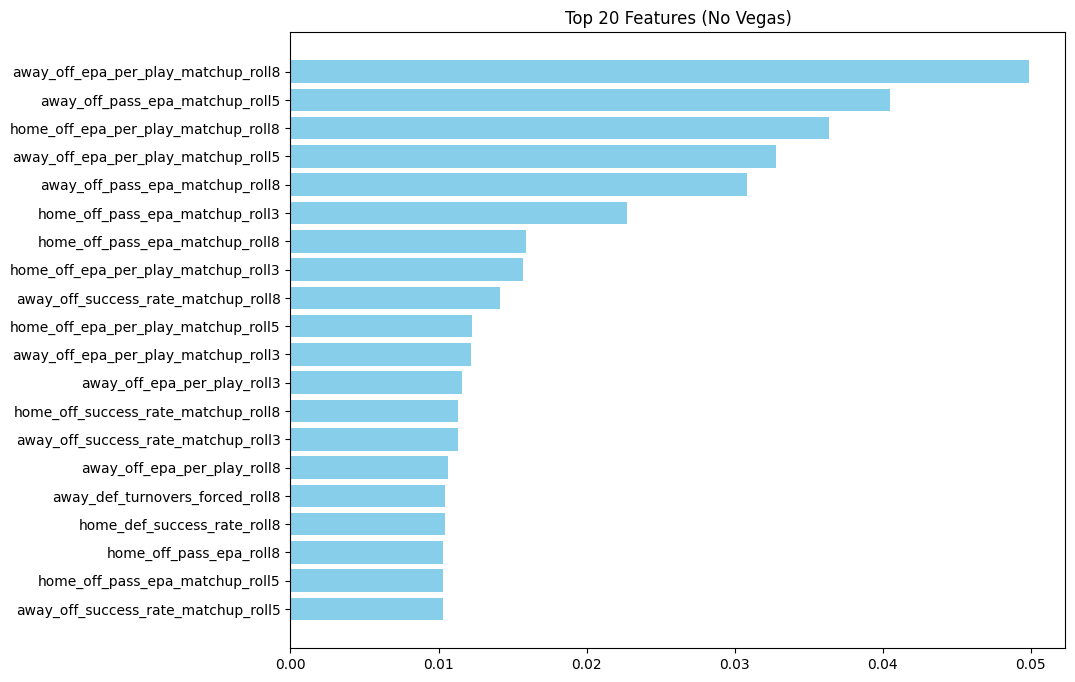

In [11]:
# 7. Evaluate
y_pred = xgb_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"🚀 XGBoost NV Accuracy: {acc * 100:.2f}%")
print(f"   (Baseline NV was: 56.99%)")

# Feature Importance Plot
importance = xgb_model.feature_importances_
imp_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
imp_df = imp_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(imp_df['Feature'], imp_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 20 Features (No Vegas)")
plt.show()

In [12]:
# 8. Save
with open(OUTPUT_DIR / "nv_xgboost_model.pkl", 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"✅ Saved XGBoost NV model.")

✅ Saved XGBoost NV model.
